## <p style='text-align: center;'> Analyse des emotions des Tweets 😀 😞 😡 </p> 

### <span style="color: Navy"> 1.Intorduction </span> 

La détection des émotions à partir de texte est un défi majeur en traitement du langage naturel (NLP) en raison du manque de jeux de données étiquetés et de leur complexité multi-classes. Les humains éprouvent une large gamme d'émotions qu'il est difficile de représenter avec suffisamment de données pour chaque émotion, entraînant un déséquilibre des classes. Ce jeu de données de classification des émotions a été compilé pour soutenir la recherche dans le domaine du NLP et de l'analyse des émotions. Il comprend une grande variété de textes étiquetés avec les émotions qu'ils véhiculent, allant de la joie à la colère et la tristesse. L'objectif est de construire un modèle efficace pour détecter les émotions à partir du texte en utilisant RNN.
lien de dataset: https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text

### <span style="color: Navy"> 2.Importation des bibliotheques </span> 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, precision_score, f1_score
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

### <span style="color: Navy"> 3.Nettoyage des données : </span> 

In [2]:
df=pd.read_csv('datasets/text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
df.duplicated().sum()

686

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(416123, 2)

In [8]:
Emotion ={0:'Sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}
df['Emotion'] = df['label'].map(Emotion)
df.head()


,text,label,Emotion
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,Sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,Sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


In [9]:
# Text preprocessing avec NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### <span style="color: Navy"> 4.Normalisation des données</span>

In [10]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()] # ne garder que les mots alphabétiques
    tokens = [word.lower() for word in tokens] # mettre en minuscule
    tokens = [word for word in tokens if not word in stop_words] # suppression des mots vides
    return ' '.join(tokens)

In [11]:
df['text'] = df['text'].apply(preprocess)

In [12]:
df.head()

,text,label,Emotion
0,feel really helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly n...,0,Sadness
2,gave internship dmrg feeling distraught,4,fear
3,dont know feel lost,0,Sadness
4,kindergarten teacher thoroughly weary job take...,4,fear


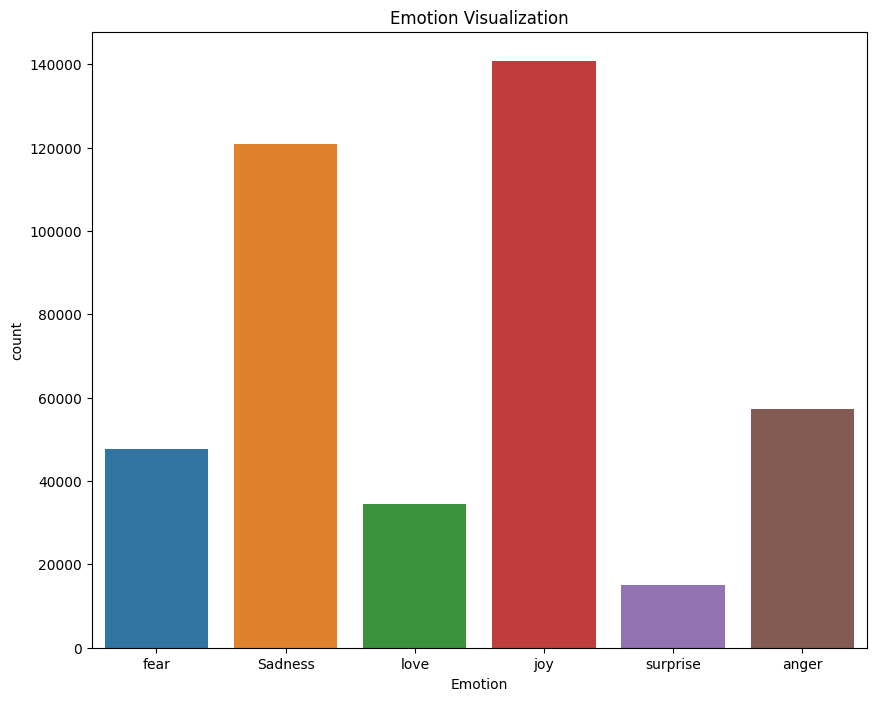

In [13]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Emotion', data=df,hue=df['Emotion'])
plt.title('Emotion Visualization')
plt.show()

### <span style="color: Navy"> 5.Encodage(Conversion des émotions en labels numériques ): </span> 

In [14]:
# Conversion des émotions en labels numériques
label_encoder = LabelEncoder()
df['emotion_label'] = label_encoder.fit_transform(df['Emotion'])

### <span style="color: Navy"> 6.Séparation des données: </span> 

In [15]:
# Séparation des variables indépendantes et de la variable cible
X = df['text']
Y = df['emotion_label']

In [16]:
# Division du dataset en ensembles d'entraînement, de validation et de test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42) 



### <span style="color: Navy"> 7.Tokenization et vectorisation des textes : </span>

In [17]:
# Création du vocabulaire et conversion des textes en séquences de nombres
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
# Conversion des textes en séquences de nombres et remplissage des séquences pour avoir la même longueur
maxlen = 100  # Longueur maximale des séquences
X_train_sequences = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_val_sequences = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)
X_test_sequences = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)


### <span style="color: Navy"> 8.Création du modèle de RNN :</span>

In [19]:


# Définir la taille du vocabulaire et créer le modèle
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
maxlen = 100  # Longueur maximale de la séquence

model = Sequential()

# Ajouter une couche d'embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

# Ajouter une couche SimpleRNN avec une dimension d'état de 128
model.add(SimpleRNN(units=128))

# Ajouter une couche dense pour la classification
model.add(Dense(6, activation='softmax'))  # 6 classes d'émotion

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



### <span style="color: Navy"> 8.Compilation et entraînement du modèle :</span>

In [20]:
# Entraînement du modèle et enregistrement de l'historique
history = model.fit(X_train_sequences, y_train, batch_size=64, epochs=5, validation_data=(X_val_sequences, y_val))

Epoch 1/5
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 575s 122ms/step - accuracy: 0.7894 - loss: 0.5647 - val_accuracy: 0.9294 - val_loss: 0.1365
Epoch 2/5
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 635s 124ms/step - accuracy: 0.9283 - loss: 0.1553 - val_accuracy: 0.9094 - val_loss: 0.2252
Epoch 3/5
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 578s 123ms/step - accuracy: 0.9311 - loss: 0.1484 - val_accuracy: 0.9273 - val_loss: 0.1258
Epoch 4/5
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 599s 128ms/step - accuracy: 0.9367 - loss: 0.1221 - val_accuracy: 0.9151 - val_loss: 0.2107
Epoch 5/5
4698/4698 ━━━━━━━━━━━━━━━━━━━━ 597s 127ms/step - accuracy: 0.9316 - loss: 0.1484 - val_accuracy: 0.9311 - val_loss: 0.1180


In [21]:
# Prédictions sur l'ensemble de test
y_pred_prob = model.predict(X_test_sequences)
y_pred = y_pred_prob.argmax(axis=-1)

1951/1951 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step



### <span style="color: Navy"> 9.Évaluation du modèle :</span>

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("accuracy :", accuracy)

accuracy : 0.9312709271215496


In [23]:
# Calcul de la précision
precision = precision_score(y_test, y_pred, average='weighted')
print("accuracy:", accuracy)


accuracy: 0.9312709271215496


In [24]:
# Calcul du score F1
f1 = f1_score(y_test, y_pred, average='weighted')
print("Score F1 (F1 score) :", f1)

Score F1 (F1 score) : 0.9314576574413843



### <span style="color: Navy"> 10.Visualisation :</span>

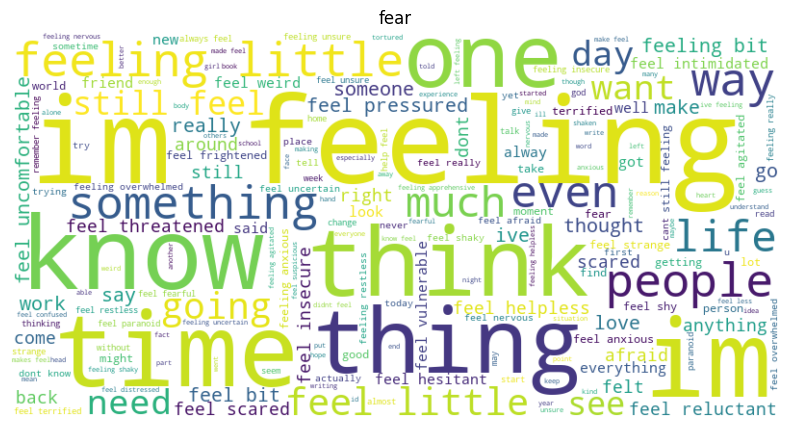

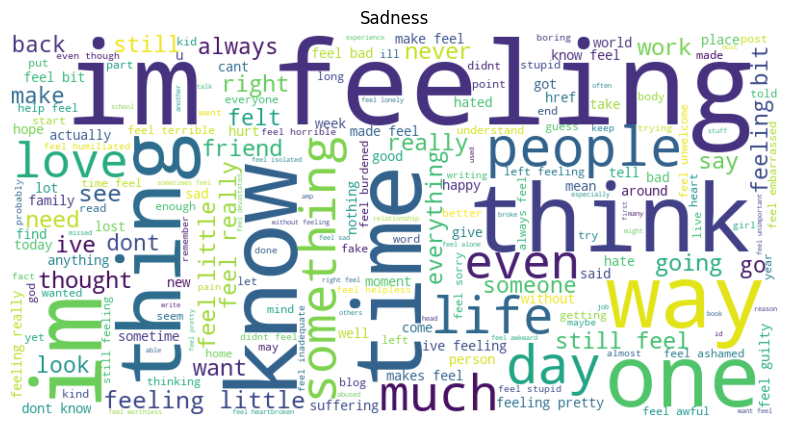

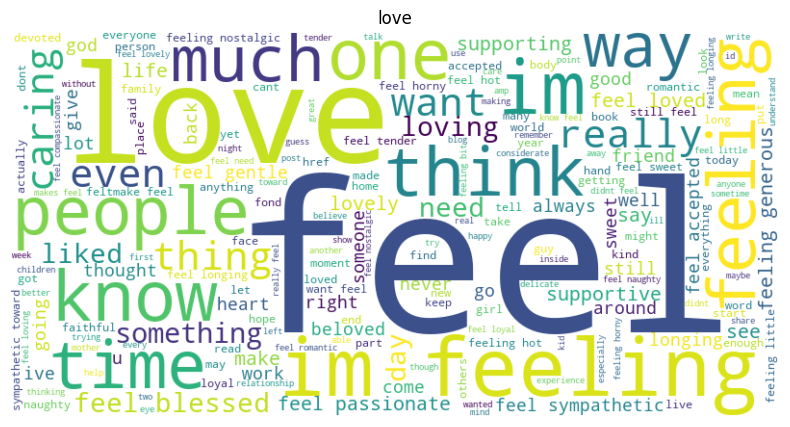

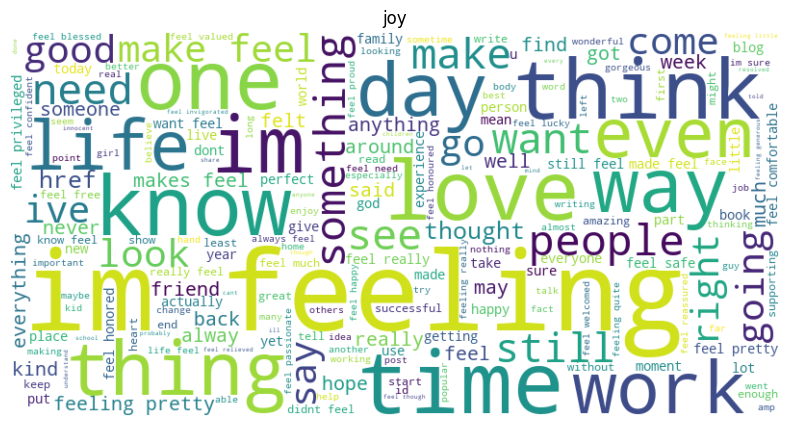

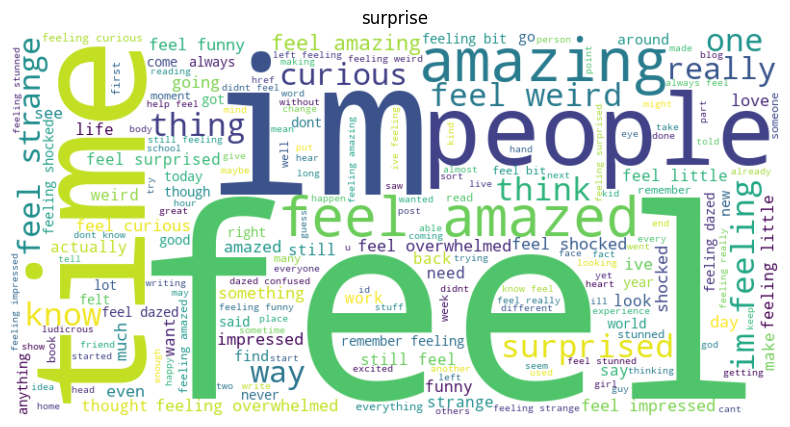

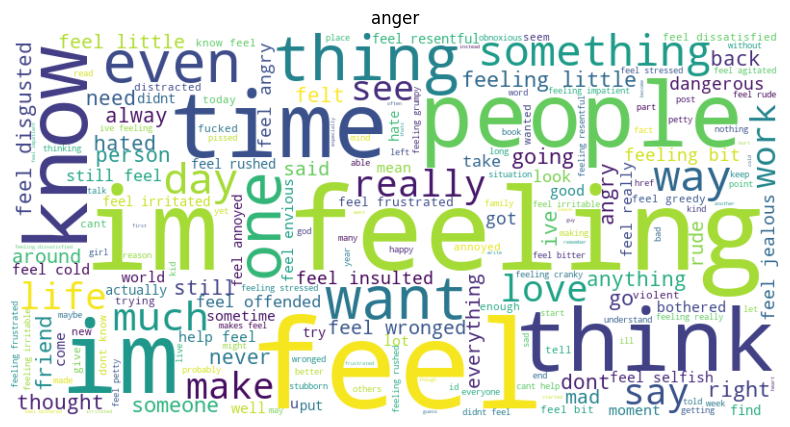

In [25]:

# Créer un dictionnaire pour stocker les textes associés à chaque émotion
emotion_texts = {}

# Filtrer les textes en fonction de l'émotion et les stocker dans le dictionnaire
for emotion in df['Emotion'].unique():
    emotion_texts[emotion] = " ".join(df[df['Emotion'] == emotion]['text'])

# Générer un nuage de mots pour chaque émotion
for emotion, text in emotion_texts.items():
    # Créer un objet WordCloud avec les paramètres appropriés
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(emotion)
    plt.axis('off')
    plt.show()


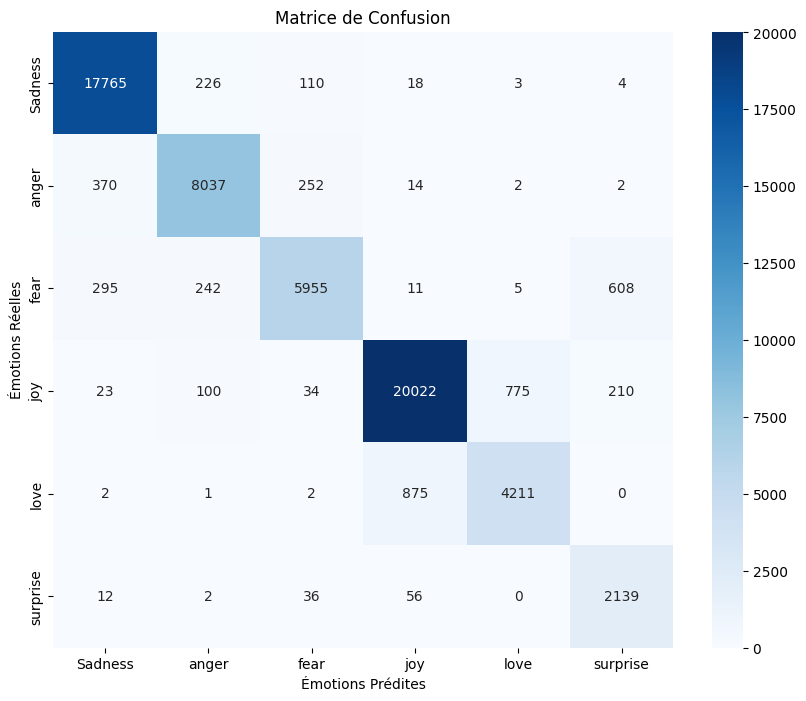

In [26]:

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Émotions Prédites')
plt.ylabel('Émotions Réelles')
plt.title('Matrice de Confusion')
plt.show()


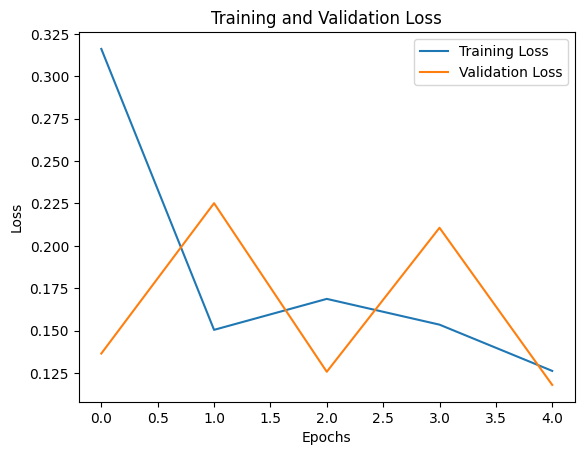

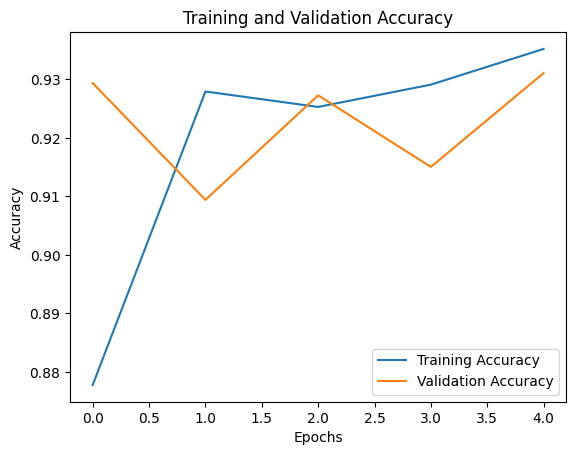

In [27]:
# Extraire les données d'historique
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### <span style="color: Navy"> 11.Prediction des nouveaux textes:</span>

In [28]:
# Fonction pour prédire l'émotion d'un texte donné
def predict_emotion(text):
    # Prétraiter le texte
    processed_text = preprocess(text)
    # Convertir le texte prétraité en séquence de nombres
    text_sequence = tokenizer.texts_to_sequences([processed_text])
    # Remplir la séquence pour avoir la même longueur que maxlen
    padded_sequence = pad_sequences(text_sequence, maxlen=maxlen)
    # Prédire l'émotion du texte
    emotion_prob = model.predict(padded_sequence)[0]
    # Obtenir l'indice de la classe ayant la probabilité la plus élevée
    predicted_class_index = emotion_prob.argmax()
    # Convertir l'indice de la classe en émotion correspondante
    predicted_emotion = label_encoder.classes_[predicted_class_index]
    return predicted_emotion

In [29]:
# Texte à prédire
text_to_predict = "After failing multiple times in my attempts to find a job, I feel depressed and discouraged."
# Prédire l'émotion du texte
predicted_emotion = predict_emotion(text_to_predict)
print("Predicted emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted emotion: Sadness


In [30]:
# Texte à prédire
text_to_predict = "I just received a promotion at work and I'm ecstatic!"
# Prédire l'émotion du texte
predicted_emotion = predict_emotion(text_to_predict)
print("Predicted emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted emotion: joy


In [31]:
import tensorflow as tf

# Sauvegarder le modèle
model.save("model_rnn_copy.h5")
# Charger le modèle
model_rnn = tf.keras.models.load_model("model_rnn.h5")


In [32]:
# Convert tokenizer to JSON format
tokenizer_json = tokenizer.to_json()

# Save the JSON to a file
with open('tokenizer_copy.json', 'w') as json_file:
    json_file.write(tokenizer_json)


In [33]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import tensorflow as tf

# Charger le JSON à partir du fichier
with open('tokenizer_copy.json') as json_file:
    tokenizer_json = json_file.read()

# Convertir le JSON en tokenizer
tokenizer = tokenizer_from_json(tokenizer_json)
# Charger le modèle
model_rnn = tf.keras.models.load_model("model_rnn_copy.h5")


In [34]:
# Fonction pour prédire l'émotion d'un texte donné
def predict_emotion(text):
    maxlen=100
    # Prétraiter le texte
    processed_text = preprocess(text)
    # Convertir le texte prétraité en séquence de nombres
    text_sequence = tokenizer.texts_to_sequences([processed_text])
    # Remplir la séquence pour avoir la même longueur que maxlen
    padded_sequence = pad_sequences(text_sequence, maxlen=maxlen)
    # Prédire l'émotion du texte
    emotion_prob = model_rnn.predict(padded_sequence)[0]
    # Obtenir l'indice de la classe ayant la probabilité la plus élevée
    predicted_class_index = emotion_prob.argmax()
    # Convertir l'indice de la classe en émotion correspondante
    return predicted_class_index

In [35]:
# Texte à prédire
text_to_predict = "Surprised party!"
# Prédire l'émotion du texte
predicted_emotion = predict_emotion(text_to_predict)
print("Predicted emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted emotion: 3


In [36]:
# Prédictions sur l'ensemble de test
y_pred_prob = model_rnn.predict(X_test_sequences)
y_pred = y_pred_prob.argmax(axis=-1)

1951/1951 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step


In [38]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import tensorflow as tf

# Charger le JSON à partir du fichier
with open('tokenizer_rnn_sans_lstm.json') as json_file:
    tokenizer_json = json_file.read()

# Convertir le JSON en tokenizer
tokenizer_rnn = tokenizer_from_json(tokenizer_json)
# Charger le modèle
model_rnn = tf.keras.models.load_model("model_rnn_sans_lstm.h5")

FileNotFoundError: [Errno 2] No such file or directory: 'tokenizer_rnn_sans_lstm.json'

In [ ]:
X_test_sequences_rnn = pad_sequences(tokenizer_rnn.texts_to_sequences(X_test), maxlen=100)

In [ ]:
y_pred_prob = model_rnn.predict(X_test_sequences_rnn)
y_pred_rnn = y_pred_prob.argmax(axis=-1)

1951/1951 ━━━━━━━━━━━━━━━━━━━━ 62s 32ms/step


In [ ]:
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')
print("Accuracy_rnn:", accuracy_rnn)
print("Precision_rnn:", precision_rnn)
print("F1 Score_rnn:", f1_rnn)

Accuracy_rnn: 0.31637802592159436
Precision_rnn: 0.3102876969871958
F1 Score_rnn: 0.312666869327667
